In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/ResidentPatient090/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-01 10:10:05 - INFO - 1408590915.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/ResidentPatient090/03/log.log', param_file='saved_models/kgc/ResidentPatient090/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/ResidentPatient090/03/checkpoint/', model_path='saved_models/kgc/ResidentPatient090/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=True, use_for_challenge075=False, use_title='ResidentPatient', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, 

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2023-01-01 10:10:06 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2023-01-01 10:10:06 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:10:06 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:10:06 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:10:06 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:10:06 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2023-01-01 10:10:06 - INFO - data_helper.py - 441 - ==========
2023-01-01 10:10:06 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:10:06 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:10:06 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:10:06 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:10:06 - INFO - data_helper.py - 443 - ==========
2023-01-01 10:10:06 - INFO - data_helper.py - 445 - entity_spec

14016 17205


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

In [14]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

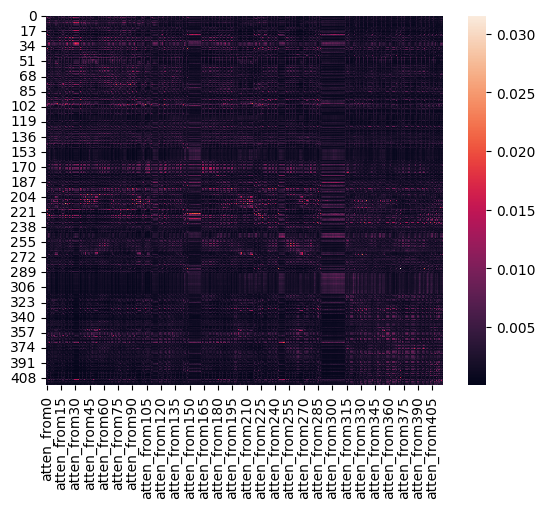

ResidentPatient:, ranking []


,predicate,whom,subject,why,what,where
0,word.predicate:exist,ResidentPatient:Young_man,ResidentPatient:Young_man,SilverBlaze:John_Straker,AllTitle:Watson,ResidentPatient:Blessington_room
1,word.predicate:kill,AllTitle:Holmes,ResidentPatient:Elderly_man,word.predicate:putInto,ResidentPatient:Helper_boy,SilverBlaze:John_Straker
2,word.predicate:sit,ResidentPatient:Blessington,ResidentPatient:Helper_boy,ResidentPatient:Blessington_room,AllTitle:Holmes,SilverBlaze:Fitzroy_Simpson
3,word.predicate:notHear,ResidentPatient:Helper_boy,AllTitle:Holmes,word.predicate:get,SilverBlaze:Silver_Blaze,ResidentPatient:Young_man
4,word.predicate:say,ResidentPatient:Elderly_man,ResidentPatient:Blessington,SpeckledBand:Julia_s_bedroom,ResidentPatient:Percy_Trevelyan,bos_e
5,bos_e,ResidentPatient:Percy_Trevelyan,ResidentPatient:Percy_Trevelyan,SilverBlaze:Fitzroy_Simpson,DevilsFoot:Mortimer,CrookedMan:Nancy
6,word.predicate:have,CrookedMan:Nancy,CrookedMan:Nancy,DevilsFoot:Owen,ResidentPatient:Blessington,CrookedMan:Morrison
7,word.predicate:hit,DevilsFoot:Sterndale,DevilsFoot:Sterndale,DevilsFoot:Sterndale,SpeckledBand:Julia_s_bedroom,DancingMen:Abe_Slaney
8,word.predicate:find,DancingMen:Cubitt,AllTitle:Watson,ResidentPatient:Helper_boy,SpeckledBand:Roylott,DevilsFoot:Owen
9,CrookedMan:Nancy,DancingMen:Elsie,DancingMen:Cubitt,word.predicate:louder,ResidentPatient:Elderly_man,CrookedMan:owner_of_lodge


397

['ResidentPatient:288', 'kgc:on', 'ResidentPatient:Chair']

,head,relation,tail,atten_from397
285,ResidentPatient:270,kgc:hasPredicate,word.predicate:cannotFind,0.020634
234,ResidentPatient:259,kgc:hasPredicate,word.predicate:cut,0.013961
36,ResidentPatient:219,kgc:hasPredicate,word.predicate:suicide,0.011137
257,ResidentPatient:264,kgc:hasProperty,word.predicate:clearly,0.010841
21,ResidentPatient:216,kgc:hasPredicate,word.predicate:write,0.009835
375,ResidentPatient:284,kgc:hasProperty,word.predicate:thick,0.009585
253,ResidentPatient:263,kgc:hasProperty,word.predicate:save,0.008949
62,ResidentPatient:224,kgc:hasProperty,word.predicate:miserably,0.008192
176,ResidentPatient:246,kgc:hasProperty,word.predicate:thin,0.007985
194,ResidentPatient:251,kgc:subject,ResidentPatient:Blessington,0.007861


----------


398

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from398
47,ResidentPatient:222,kgc:subject,ResidentPatient:maid,0.005885
218,ResidentPatient:256,kgc:subject,AllTitle:Holmes,0.004916
100,ResidentPatient:232,kgc:subject,AllTitle:Watson,0.004767
49,ResidentPatient:222,kgc:what,ResidentPatient:cadaver,0.004661
144,ResidentPatient:241,kgc:subject,AllTitle:Holmes,0.004534
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.004322
26,bos_e,bos_r,bos_e,0.004112
102,ResidentPatient:232,kgc:what,ResidentPatient:233,0.004092
34,bos_e,bos_r,bos_e,0.004005
117,bos_e,bos_r,bos_e,0.003968


----------


399

['ResidentPatient:289', 'kgc:subject', 'ResidentPatient:Elderly_man']

,head,relation,tail,atten_from399
233,ResidentPatient:259,kgc:subject,ResidentPatient:Blessington,0.014361
194,ResidentPatient:251,kgc:subject,ResidentPatient:Blessington,0.011593
407,ResidentPatient:291,kgc:subject,ResidentPatient:Helper_boy,0.010843
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.009947
124,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.008923
240,ResidentPatient:261,kgc:subject,ResidentPatient:Blessington,0.008690
334,ResidentPatient:276,kgc:subject,ResidentPatient:Helper_boy,0.008155
227,ResidentPatient:258,kgc:subject,ResidentPatient:Percy_Trevelyan,0.008132
403,ResidentPatient:290,kgc:subject,ResidentPatient:Young_man,0.008088
90,ResidentPatient:230,kgc:subject,ResidentPatient:Blessington,0.007669


----------


400

['ResidentPatient:289', 'kgc:hasPredicate', 'word.predicate:smoke']

,head,relation,tail,atten_from400
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.007185
375,ResidentPatient:284,kgc:hasProperty,word.predicate:thick,0.007131
257,ResidentPatient:264,kgc:hasProperty,word.predicate:clearly,0.006616
312,ResidentPatient:271,kgc:what,ResidentPatient:294,0.006509
303,ResidentPatient:271,kgc:what,ResidentPatient:285,0.006038
230,ResidentPatient:258,kgc:what,ResidentPatient:260,0.005996
302,ResidentPatient:271,kgc:what,ResidentPatient:284,0.005947
304,ResidentPatient:271,kgc:what,ResidentPatient:286,0.005807
295,ResidentPatient:271,kgc:what,ResidentPatient:277,0.005710
290,ResidentPatient:271,kgc:what,ResidentPatient:272,0.005709


----------


401

['ResidentPatient:289', 'kgc:what', 'ResidentPatient:cigar']

,head,relation,tail,atten_from401
224,ResidentPatient:257,kgc:what,ResidentPatient:That_of_the_rope,0.013619
228,ResidentPatient:258,kgc:hasPredicate,word.predicate:say,0.010768
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.010607
223,ResidentPatient:257,kgc:hasPredicate,word.predicate:ask,0.008489
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.007199
216,ResidentPatient:255,kgc:time,DateTime:1889-10-21T05:30:00,0.007156
21,ResidentPatient:216,kgc:hasPredicate,word.predicate:write,0.006891
286,ResidentPatient:270,kgc:whom,ResidentPatient:Helper_boy,0.006629
368,ResidentPatient:282,kgc:infoSource,AllTitle:Holmes,0.006571
222,ResidentPatient:257,kgc:subject,AllTitle:Holmes,0.006348


----------


402

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from402
47,ResidentPatient:222,kgc:subject,ResidentPatient:maid,0.005591
100,ResidentPatient:232,kgc:subject,AllTitle:Watson,0.004937
49,ResidentPatient:222,kgc:what,ResidentPatient:cadaver,0.004844
218,ResidentPatient:256,kgc:subject,AllTitle:Holmes,0.004765
144,ResidentPatient:241,kgc:subject,AllTitle:Holmes,0.004746
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.004642
102,ResidentPatient:232,kgc:what,ResidentPatient:233,0.004429
219,ResidentPatient:256,kgc:hasPredicate,word.predicate:examine,0.004050
26,bos_e,bos_r,bos_e,0.004030
34,bos_e,bos_r,bos_e,0.003948


----------


403

['ResidentPatient:290', 'kgc:subject', 'ResidentPatient:Young_man']

,head,relation,tail,atten_from403
233,ResidentPatient:259,kgc:subject,ResidentPatient:Blessington,0.017220
401,ResidentPatient:289,kgc:what,ResidentPatient:cigar,0.010511
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.010049
227,ResidentPatient:258,kgc:subject,ResidentPatient:Percy_Trevelyan,0.009608
405,ResidentPatient:290,kgc:what,ResidentPatient:Ash,0.009121
412,mask_e,kgc:whom,ResidentPatient:Blessington,0.008635
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.008491
407,ResidentPatient:291,kgc:subject,ResidentPatient:Helper_boy,0.008461
399,ResidentPatient:289,kgc:subject,ResidentPatient:Elderly_man,0.008214
284,ResidentPatient:270,kgc:subject,ResidentPatient:Percy_Trevelyan,0.008141


----------


404

['ResidentPatient:290', 'kgc:hasPredicate', 'word.predicate:drop']

,head,relation,tail,atten_from404
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.009460
393,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.008578
381,ResidentPatient:285,kgc:what,ResidentPatient:Means_of_conviction,0.007948
249,ResidentPatient:262,kgc:what,ResidentPatient:267,0.007597
351,ResidentPatient:279,kgc:what,ResidentPatient:door,0.007521
230,ResidentPatient:258,kgc:what,ResidentPatient:260,0.007478
342,ResidentPatient:277,kgc:what,ResidentPatient:278,0.007257
245,ResidentPatient:262,kgc:what,ResidentPatient:263,0.006971
405,ResidentPatient:290,kgc:what,ResidentPatient:Ash,0.006945
231,ResidentPatient:258,kgc:what,ResidentPatient:261,0.006905


----------


405

['ResidentPatient:290', 'kgc:what', 'ResidentPatient:Ash']

,head,relation,tail,atten_from405
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.012500
248,ResidentPatient:262,kgc:what,ResidentPatient:266,0.008954
228,ResidentPatient:258,kgc:hasPredicate,word.predicate:say,0.008453
224,ResidentPatient:257,kgc:what,ResidentPatient:That_of_the_rope,0.008433
231,ResidentPatient:258,kgc:what,ResidentPatient:261,0.008291
249,ResidentPatient:262,kgc:what,ResidentPatient:267,0.008219
212,ResidentPatient:255,kgc:hasPredicate,word.predicate:lock,0.007958
230,ResidentPatient:258,kgc:what,ResidentPatient:260,0.007419
21,ResidentPatient:216,kgc:hasPredicate,word.predicate:write,0.007318
245,ResidentPatient:262,kgc:what,ResidentPatient:263,0.007298


----------


406

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from406
47,ResidentPatient:222,kgc:subject,ResidentPatient:maid,0.006198
49,ResidentPatient:222,kgc:what,ResidentPatient:cadaver,0.005403
218,ResidentPatient:256,kgc:subject,AllTitle:Holmes,0.004955
100,ResidentPatient:232,kgc:subject,AllTitle:Watson,0.004805
102,ResidentPatient:232,kgc:what,ResidentPatient:233,0.004601
144,ResidentPatient:241,kgc:subject,AllTitle:Holmes,0.004513
50,ResidentPatient:222,kgc:where,ResidentPatient:Blessington_room,0.004394
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.004388
55,ResidentPatient:222a,kgc:subject,ResidentPatient:cadaver,0.004226
26,bos_e,bos_r,bos_e,0.004129


----------


407

['ResidentPatient:291', 'kgc:subject', 'ResidentPatient:Helper_boy']

,head,relation,tail,atten_from407
233,ResidentPatient:259,kgc:subject,ResidentPatient:Blessington,0.017949
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.012925
407,ResidentPatient:291,kgc:subject,ResidentPatient:Helper_boy,0.010369
284,ResidentPatient:270,kgc:subject,ResidentPatient:Percy_Trevelyan,0.010020
227,ResidentPatient:258,kgc:subject,ResidentPatient:Percy_Trevelyan,0.009999
358,ResidentPatient:281,kgc:subject,ResidentPatient:Young_man,0.009110
412,mask_e,kgc:whom,ResidentPatient:Blessington,0.009048
364,ResidentPatient:282,kgc:subject,ResidentPatient:Young_man,0.008935
240,ResidentPatient:261,kgc:subject,ResidentPatient:Blessington,0.008698
405,ResidentPatient:290,kgc:what,ResidentPatient:Ash,0.008396


----------


408

['ResidentPatient:291', 'kgc:hasPredicate', 'word.predicate:wander']

,head,relation,tail,atten_from408
381,ResidentPatient:285,kgc:what,ResidentPatient:Means_of_conviction,0.010860
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.010643
230,ResidentPatient:258,kgc:what,ResidentPatient:260,0.010108
393,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.009534
231,ResidentPatient:258,kgc:what,ResidentPatient:261,0.009333
213,ResidentPatient:255,kgc:what,ResidentPatient:Obex,0.008491
245,ResidentPatient:262,kgc:what,ResidentPatient:263,0.008028
405,ResidentPatient:290,kgc:what,ResidentPatient:Ash,0.007939
250,ResidentPatient:262,kgc:what,ResidentPatient:268,0.007857
235,ResidentPatient:259,kgc:what,ResidentPatient:Wheel_of_a_large_rope,0.007225


----------


409

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from409
47,ResidentPatient:222,kgc:subject,ResidentPatient:maid,0.006470
49,ResidentPatient:222,kgc:what,ResidentPatient:cadaver,0.005182
100,ResidentPatient:232,kgc:subject,AllTitle:Watson,0.005000
218,ResidentPatient:256,kgc:subject,AllTitle:Holmes,0.004815
102,ResidentPatient:232,kgc:what,ResidentPatient:233,0.004736
144,ResidentPatient:241,kgc:subject,AllTitle:Holmes,0.004717
55,ResidentPatient:222a,kgc:subject,ResidentPatient:cadaver,0.004699
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.004329
50,ResidentPatient:222,kgc:where,ResidentPatient:Blessington_room,0.004212
26,bos_e,bos_r,bos_e,0.004124


----------


410

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from410
223,ResidentPatient:257,kgc:hasPredicate,word.predicate:ask,0.013377
411,mask_e,kgc:hasPredicate,word.predicate:kill,0.011580
234,ResidentPatient:259,kgc:hasPredicate,word.predicate:cut,0.010892
331,ResidentPatient:275,kgc:hasPredicate,word.predicate:walk,0.010850
400,ResidentPatient:289,kgc:hasPredicate,word.predicate:smoke,0.010836
285,ResidentPatient:270,kgc:hasPredicate,word.predicate:cannotFind,0.008745
335,ResidentPatient:276,kgc:hasPredicate,word.predicate:walk,0.008662
208,ResidentPatient:254,kgc:hasPredicate,word.predicate:enter,0.008405
392,ResidentPatient:287,kgc:hasPredicate,word.predicate:smoke,0.008399
101,ResidentPatient:232,kgc:hasPredicate,word.predicate:say,0.007919


----------


411

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from411
393,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.011800
229,ResidentPatient:258,kgc:what,ResidentPatient:259,0.010507
231,ResidentPatient:258,kgc:what,ResidentPatient:261,0.010215
230,ResidentPatient:258,kgc:what,ResidentPatient:260,0.008664
342,ResidentPatient:277,kgc:what,ResidentPatient:278,0.008342
401,ResidentPatient:289,kgc:what,ResidentPatient:cigar,0.007717
405,ResidentPatient:290,kgc:what,ResidentPatient:Ash,0.007578
381,ResidentPatient:285,kgc:what,ResidentPatient:Means_of_conviction,0.007426
213,ResidentPatient:255,kgc:what,ResidentPatient:Obex,0.006359
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.006226


----------


412

['mask_e', 'kgc:whom', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from412
233,ResidentPatient:259,kgc:subject,ResidentPatient:Blessington,0.010812
399,ResidentPatient:289,kgc:subject,ResidentPatient:Elderly_man,0.009622
208,ResidentPatient:254,kgc:hasPredicate,word.predicate:enter,0.009424
339,ResidentPatient:277,kgc:subject,ResidentPatient:Young_man,0.008642
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.008151
284,ResidentPatient:270,kgc:subject,ResidentPatient:Percy_Trevelyan,0.008067
331,ResidentPatient:275,kgc:hasPredicate,word.predicate:walk,0.008059
227,ResidentPatient:258,kgc:subject,ResidentPatient:Percy_Trevelyan,0.007857
391,ResidentPatient:287,kgc:subject,ResidentPatient:Helper_boy,0.007751
390,ResidentPatient:287,kgc:subject,ResidentPatient:Young_man,0.007467


----------


413

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from413
233,ResidentPatient:259,kgc:subject,ResidentPatient:Blessington,0.014437
330,ResidentPatient:275,kgc:subject,ResidentPatient:Young_man,0.009642
407,ResidentPatient:291,kgc:subject,ResidentPatient:Helper_boy,0.009451
399,ResidentPatient:289,kgc:subject,ResidentPatient:Elderly_man,0.009422
364,ResidentPatient:282,kgc:subject,ResidentPatient:Young_man,0.008978
365,ResidentPatient:282,kgc:subject,ResidentPatient:Helper_boy,0.008666
227,ResidentPatient:258,kgc:subject,ResidentPatient:Percy_Trevelyan,0.008389
410,mask_e,kgc:infoSource,AllTitle:Holmes,0.008305
403,ResidentPatient:290,kgc:subject,ResidentPatient:Young_man,0.008157
194,ResidentPatient:251,kgc:subject,ResidentPatient:Blessington,0.007918


----------


414

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from414
216,ResidentPatient:255,kgc:time,DateTime:1889-10-21T05:30:00,0.016035
269,ResidentPatient:266,kgc:time,DateTime:1889-10-21T05:00:00,0.008036
234,ResidentPatient:259,kgc:hasPredicate,word.predicate:cut,0.008006
381,ResidentPatient:285,kgc:what,ResidentPatient:Means_of_conviction,0.006540
249,ResidentPatient:262,kgc:what,ResidentPatient:267,0.006501
66,ResidentPatient:225,kgc:what,ResidentPatient:Sleepwear,0.006224
98,ResidentPatient:231,kgc:time,DateTime:1889-10-21T05:00:00,0.005987
32,ResidentPatient:218,kgc:what,ResidentPatient:222,0.005798
31,ResidentPatient:218,kgc:what,ResidentPatient:221,0.005750
188,ResidentPatient:249,kgc:what,ResidentPatient:two_butts_of_Cigar,0.005623


----------


415

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from415
411,mask_e,kgc:hasPredicate,word.predicate:kill,0.013229
234,ResidentPatient:259,kgc:hasPredicate,word.predicate:cut,0.010052
31,ResidentPatient:218,kgc:what,ResidentPatient:221,0.008369
410,mask_e,kgc:infoSource,AllTitle:Holmes,0.007778
212,ResidentPatient:255,kgc:hasPredicate,word.predicate:lock,0.007330
360,ResidentPatient:281,kgc:hasPredicate,word.predicate:enter,0.007263
21,ResidentPatient:216,kgc:hasPredicate,word.predicate:write,0.006910
216,ResidentPatient:255,kgc:time,DateTime:1889-10-21T05:30:00,0.006499
66,ResidentPatient:225,kgc:what,ResidentPatient:Sleepwear,0.006410
331,ResidentPatient:275,kgc:hasPredicate,word.predicate:walk,0.006400


----------


416

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from416
213,ResidentPatient:255,kgc:what,ResidentPatient:Obex,0.011498
216,ResidentPatient:255,kgc:time,DateTime:1889-10-21T05:30:00,0.010533
269,ResidentPatient:266,kgc:time,DateTime:1889-10-21T05:00:00,0.010126
249,ResidentPatient:262,kgc:what,ResidentPatient:267,0.008916
253,ResidentPatient:263,kgc:hasProperty,word.predicate:save,0.007543
248,ResidentPatient:262,kgc:what,ResidentPatient:266,0.007069
332,ResidentPatient:275,kgc:where,ResidentPatient:middle,0.006454
168,ResidentPatient:244,kgc:hasProperty,word.predicate:imported,0.006302
381,ResidentPatient:285,kgc:what,ResidentPatient:Means_of_conviction,0.006294
31,ResidentPatient:218,kgc:what,ResidentPatient:221,0.006191


----------


In [15]:
title = 'ResidentPatient'
victim_name = 'Blessington'
killer_name = ''
last_index = 291
story_len = 80

df_ranking_Blessington, df_attension_Blessington = main_func01(title, victim_name, killer_name, last_index, story_len)